In [34]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
import numpy as np
import pandas as pd


In [4]:
#import training set
housing_train = pd.read_csv('datasets/housing/Housing_train.csv')
#import test set
housing_test = pd.read_csv('datasets/housing/Housing_test.csv')

#create a copy of the training data to work with
housing = housing_train.copy()


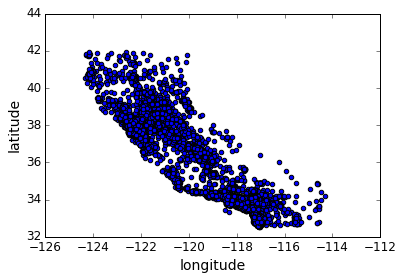

In [5]:
#Visualize Geographical data
housing.plot(kind="scatter", x="longitude", y ="latitude")

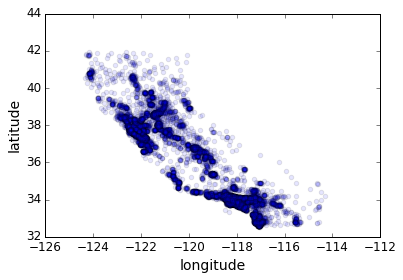

In [6]:
#Visualize Geographical data with trasparent points
housing.plot(kind="scatter", x="longitude",y="latitude", alpha=0.1)

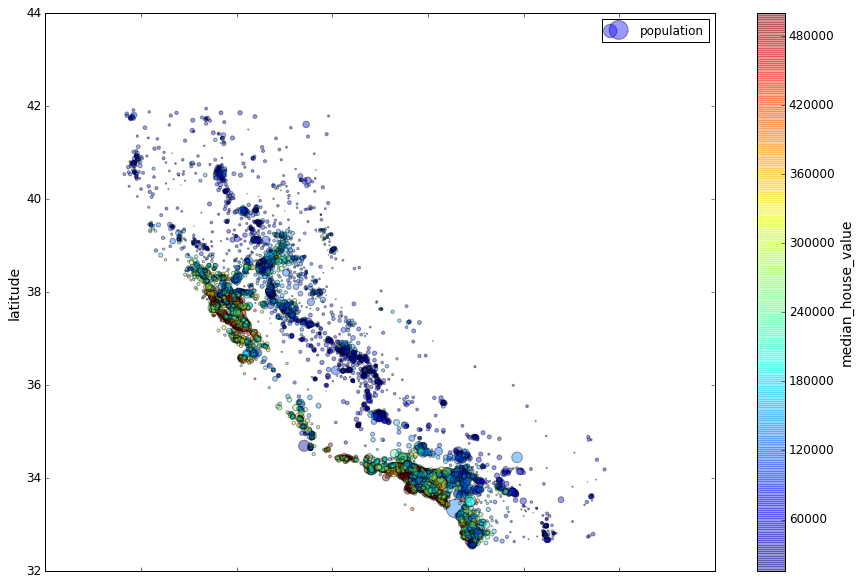

In [7]:
#Add population and housing price 
housing.plot(kind='scatter',x="longitude",y="latitude",alpha=0.4,s=housing["population"]/100, label="population",
            c="median_house_value", cmap=plt.get_cmap("jet"),colorbar=True, figsize=(15,10))
plt.legend()

## Create Correlation Matrix

In [8]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
income_cat            0.642274
total_rooms           0.135097
housing_median_age    0.114110
Unnamed: 0            0.067723
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000A32A588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000BF556A0>]], dtype=object)

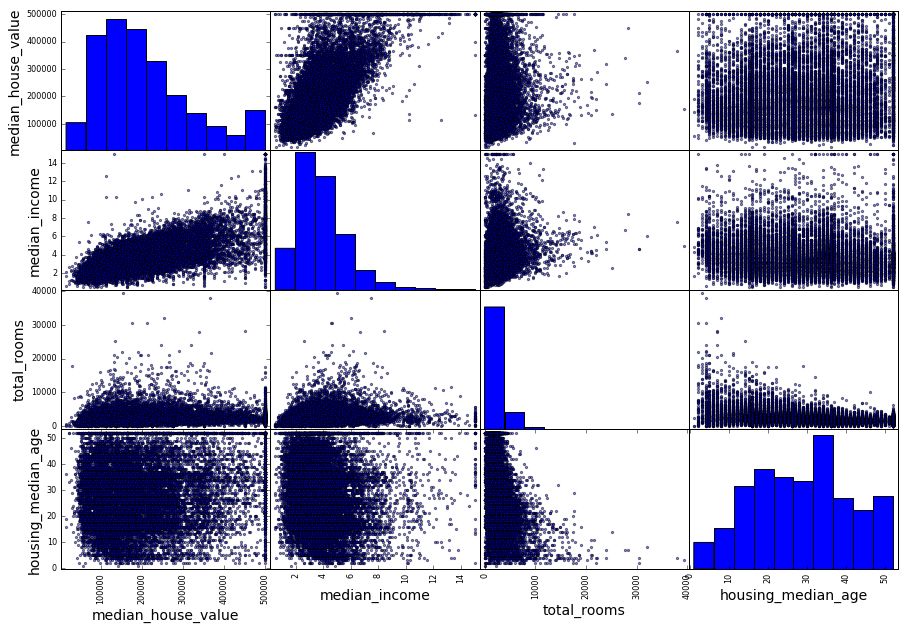

In [9]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
pd.tools.plotting.scatter_matrix(housing[attributes],figsize=(15,10))

## Data Cleaning

In [11]:
#Fill in missing values using Imputer

from sklearn.preprocessing import Imputer

#create a copy of the data set without the ocean proximity in order to calculate the median
housing_num = housing.drop("ocean_proximity", axis=1)

#Create new dataset that has missing values replaced with the median value
imputer = Imputer(strategy = "median")
imputer.fit(housing_num)

Imputer(axis=0, copy=True, missing_values='NaN', strategy=u'median',
    verbose=0)

In [12]:
imputer.statistics_

array([  1.03410000e+04,  -1.18510000e+02,   3.42600000e+01,
         2.90000000e+01,   2.11950000e+03,   4.33000000e+02,
         1.16400000e+03,   4.08000000e+02,   3.54090000e+00,
         1.79500000e+05,   3.00000000e+00])

In [13]:
housing_num.median().values

array([  1.03410000e+04,  -1.18510000e+02,   3.42600000e+01,
         2.90000000e+01,   2.11950000e+03,   4.33000000e+02,
         1.16400000e+03,   4.08000000e+02,   3.54090000e+00,
         1.79500000e+05,   3.00000000e+00])

In [14]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

### Handeling Text and Categorical Attributes

In [16]:
#transform "ocean proximity" category into a numerical lablel
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded

array([0, 0, 4, ..., 1, 0, 3], dtype=int64)

In [17]:
print(encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [19]:
#for this application, it makes more sense to use 'one-hot-coding' which is binary to represent when a 
#property is near the ocean or not near the ocean

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<type 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [20]:
#Both of the last two steps (housing_cat --> housing_cat_encoded and housing_cat_encoded --> housing_cat_1hot) can be 
#combined into one step using LabelBinarizer, this also will create a dense matrix instead of a sparse matrix

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

### Creating Custom Transformers

#### SKLearn provides many transforms, but if custom ones are used they must include fit(), transform(), and fit_transform() functions
#### in order to be used with pipelines

In [23]:
#Example Custom Transform to combine attributes

from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): #no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self #nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:,rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:,household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

### Transformation Pipelines

In [28]:
#The selector class needs to be defined to transform from Pandas DF to Numpy Array

from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

In [44]:
# Pipelines allows for a series of transforms to be conducted in series
# FeatureUnion allows for parallel piplines to be formed that join the data at the end

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', LabelBinarizer()),
    ])

full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipline", num_pipeline),
        ("cat_pipline", cat_pipeline),
    ])


In [45]:
#Run pipeline

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

TypeError: fit_transform() takes exactly 2 arguments (3 given)